In [1]:
import pandas as pd

coverage = pd.read_csv("../dataset/jacoco.csv")[['PACKAGE', 'CLASS', 'LINE_COVERED', 'LINE_MISSED']]
coverage.head()

,PACKAGE,CLASS,LINE_COVERED,LINE_MISSED
0,org.springframework.samples.petclinic,PetclinicInitializer,24,0
1,org.springframework.samples.petclinic.model,NamedEntity,4,1
2,org.springframework.samples.petclinic.model,Specialty,1,0
3,org.springframework.samples.petclinic.model,PetType,1,0
4,org.springframework.samples.petclinic.model,Vets,0,4


In [2]:
coverage['lines'] = coverage.LINE_COVERED + coverage.LINE_MISSED
coverage['ratio'] = coverage.LINE_COVERED / coverage.lines
coverage.head()

,PACKAGE,CLASS,LINE_COVERED,LINE_MISSED,lines,ratio
0,org.springframework.samples.petclinic,PetclinicInitializer,24,0,24,1.0
1,org.springframework.samples.petclinic.model,NamedEntity,4,1,5,0.8
2,org.springframework.samples.petclinic.model,Specialty,1,0,1,1.0
3,org.springframework.samples.petclinic.model,PetType,1,0,1,1.0
4,org.springframework.samples.petclinic.model,Vets,0,4,4,0.0


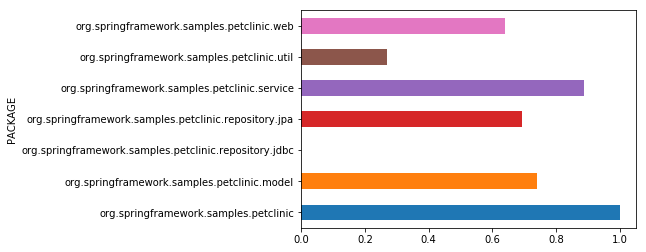

In [3]:
%matplotlib inline

coverage.groupby("PACKAGE").mean()['ratio'].plot(kind='barh')

In [4]:
import py2neo

graph = py2neo.Graph()

query="""
MATCH (t:Type)
RETURN t.fqn LIMIT 10
"""

pd.DataFrame(graph.data(query))

,t.fqn
0,org.springframework.samples.petclinic.model.Ba...
1,java.lang.Object
2,javax.persistence.MappedSuperclass
3,java.lang.Integer
4,javax.persistence.Id
5,javax.persistence.GeneratedValue
6,javax.persistence.GenerationType
7,java.lang.Enum
8,void
9,boolean


In [5]:
coverage['fqn'] = coverage.PACKAGE + "." + coverage.CLASS
coverage[['fqn', 'ratio']].head()

,fqn,ratio
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Pe...,1.0
4,org.springframework.samples.petclinic.model.Vets,0.0


Laden der Coverage-Informationen in die Graphdatenbank

In [6]:
query="""
    UNWIND {coverage_data} as coverage
    MATCH (t:Type {fqn : coverage.fqn})
    MERGE (t)-[:HAS_MEASURE]->(m)
    SET 
        m:Measure:Coverage, 
        m.ratio = coverage.ratio
    RETURN t.fqn as fqn, m.ratio as ratio
"""

result = graph.run(query, coverage_data=coverage.to_dict(orient='records')).data()
pd.DataFrame(result).head()

,fqn,ratio
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Pe...,1.0
4,org.springframework.samples.petclinic.model.Vets,0.0


In [7]:
query = """
MATCH 
  (t:Type)-[:BELONGS_TO]->(s:Subdomain),
  (t)-[:HAS_CHANGE]->(ch:Change),
  (t)-[:HAS_MEASURE]->(co:Coverage)
OPTIONAL MATCH
  (t)-[:HAS_BUG]->(b:BugInstance)   
RETURN 
  s.name as ASubdomain,
  COUNT(DISTINCT t) as Types,
  COUNT(DISTINCT ch) as Changes,
  AVG(co.ratio) as Coverage,
  COUNT(DISTINCT b) as Bugs
ORDER BY Coverage ASC, Bugs DESC
"""
pd.DataFrame(graph.data(query))

,ASubdomain,Bugs,Changes,Coverage,Types
0,Vet,0,75,0.170000,5
1,Visit,0,90,0.368056,6
2,Pet,1,165,0.488737,11
3,Owner,3,94,0.506932,4
4,crossfunctional,2,53,0.589231,5
5,Clinic,0,26,0.888889,1
6,Person,0,5,1.000000,1
7,Specialty,0,4,1.000000,1


In [8]:
query = """
MATCH 
  (t:Type)-[:IS_A]->(ta:TechnicalAspect),
  (t)-[:HAS_CHANGE]->(ch:Change),
  (t)-[:HAS_MEASURE]->(co:Coverage)
OPTIONAL MATCH
  (t)-[:HAS_BUG]->(b:BugInstance)   
RETURN 
  ta.name as ATechnicalAspect,
  COUNT(DISTINCT t) as Types,
  COUNT(DISTINCT ch) as Changes,
  AVG(co.ratio) as Coverage,
  COUNT(DISTINCT b) as Bugs
ORDER BY Coverage ASC, Bugs DESC
"""
pd.DataFrame(graph.data(query))

,ATechnicalAspect,Bugs,Changes,Coverage,Types
0,jdbc,1,152,0.000000,8
1,util,2,23,0.371429,2
2,web,2,154,0.618818,7
3,jpa,0,54,0.702501,4
4,model,1,91,0.731240,10
5,service,0,26,0.888889,1
6,petclinic,0,5,1.000000,1
